In [1]:
pip install pymupdf4llm langchain-ollama langchain-text-splitters langchain-community faiss-cpu langgraph

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\catar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
!pip install fuzzywuzzy
!pip install autocorrect
!pip install langchain-ollama --upgrade
!pip install jupyterlab --upgrade
!pip install -U langchain-ollama

# Load Document

In [114]:
import os

documents_dir = "documents/"
target_folders = ["Condotril", "Duobiotic", "Neurofil"]  # nomes dos produtos
documents = {folder: "" for folder in target_folders}  # Inicializa um dicionário para cada produto

for folder in target_folders:
    folder_path = os.path.join(documents_dir, folder)
    
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for doc_name in os.listdir(folder_path):
            if doc_name.endswith(".txt"):
                print(f"txt encontrado ({doc_name})!")
                file_path = os.path.join(folder_path, doc_name)
                with open(file_path, "r", encoding="utf-8") as doc:
                    content = doc.read()
                    documents[folder] += content + "\n"

txt encontrado (Condotril_bula.txt)!
txt encontrado (Duobiotic_bula.txt)!
txt encontrado (Neurofil_bula.txt)!


In [115]:
documents

{'Condotril': '=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dicálcico; Cartilagem de 

# Question Generator

In [116]:
from langchain_ollama.llms import OllamaLLM

model = OllamaLLM(model="llama3.1")

# original questions

questions = ["Quais sao os ingredientes do Condotril?",
"Quais sao os ingredientes do Duobiotic?",
"Quais sao os ingredientes do Neurofil?",
"Quais sao os efeitos do Condotril?",
"Quais sao os efeitos do Duobiotic?",
"Quais sao os efeitos do Neurofil?",
"Qual e o processo de toma do Condotril?",
"Qual e o processo de toma do Duobiotic?",
"Qual e o processo de toma do Neurofil?",
"Quais sao as condicoes de armazenamento do Condotril?",
"Quais sao as condicoes de armazenamento do Duobiotic?",
"Quais sao as condicoes de armazenamento do Neurofil?",
"Em que casos nao se pode tomar Condotril?",
"Em que casos nao se pode tomar Duobiotic?",
"Em que casos nao se pode tomar Neurofil?",
"Quantas doses tem a embalagem do Condotril?",
"Quantas doses tem a embalagem do Duobiotic?",
"Quantas doses tem a embalagem do Neurofil?"]

### Variants

In [156]:
def generate_variants(model, questions, n=4):
    variants = {}
    for question in questions:
        system_prompt =  """Your role is to rephrase this question in different ways, keeping the meaning: {question}.
        Never give a question in english, only in portuguese. All the given rephrases have to be complete and full-""".format(question=question)

        response = model.generate(prompts=[system_prompt], num_return_sequences=n)
        variants[question] = [variant for variant in response.generations]
    return variants

In [157]:
question_variants = generate_variants(model, questions, n=4)

In [159]:
for original, variants in question_variants.items():
    print(f"Original: {original}")
    for i, variant in enumerate(variants, 1):
        print(f"Variant {i}: {variant}")
    print()

Original: Quais sao os ingredientes do Condotril?
Variant 1: [GenerationChunk(text='Here are some rephrased versions of the question:\n\n1. Qual é o composto que forma o Condotril?\n2. Quais são os constituintes do Condotril?\n3. O que faz parte da composição do Condotril?\n4. Quais ingredientes ou substâncias são encontradas no Condotril?\n5. De que componentes é feito o Condotril?', generation_info={'model': 'llama3.1', 'created_at': '2024-11-23T23:11:22.3827758Z', 'response': '', 'done': True, 'done_reason': 'stop', 'context': [128006, 882, 128007, 271, 7927, 3560, 374, 311, 312, 28810, 420, 3488, 304, 2204, 5627, 11, 10494, 279, 7438, 25, 3489, 2852, 104372, 2709, 25795, 288, 656, 1221, 16510, 31660, 30, 627, 286, 15037, 3041, 264, 3488, 304, 30063, 11, 1193, 304, 2700, 773, 36554, 13, 2052, 279, 2728, 312, 764, 27663, 617, 311, 387, 4686, 323, 2539, 12, 128009, 128006, 78191, 128007, 271, 8586, 527, 1063, 312, 764, 81, 1503, 11028, 315, 279, 3488, 1473, 16, 13, 20143, 4046, 297, 1

### Display and dictionary

In [ ]:
import re

var = {}

for original, variants in question_variants.items():
    QV = []
    
    #return re.sub(r"[^\w\s\!\?\.\']", "", text)
    for variant in variants:
        responses = re.split(r'\n\*|\n,', variant[0].text)
        responses = [resp.strip() 
                     for resp in responses[1:] if resp.strip()]
        QV.extend(responses)
    
    var[original] = QV

print(var)

for original, variants in var.items():
    print(f"Original: {original}")
    for i, variant in enumerate(variants, 1):
        print(f"Variante {i}: {variant}")
    print()


{'Quais sao os ingredientes do Condotril?': ['1. Qual é o composto que forma o Condotril?', '2. Quais são os constituintes do Condotril?', '3. O que faz parte da composição do Condotril?', '4. Quais ingredientes ou substâncias são encontradas no Condotril?', '5. De que componentes é feito o Condotril?'], 'Quais sao os ingredientes do Duobiotic?': ['1. O que contém o medicamento Duobiotic?', '2. Quais são os componentes ativos do Duobiotic?', '3. Em que ingredientes é composto o medicamento Duobiotic?', '4. Qual a composição química do Duobiotic?', '5. Que substâncias fazem parte da fórmula do Duobiotic?', '6. Quais são as substâncias principais presentes no Duobiotic?', '7. O que é feito de dentro do medicamento Duobiotic?', '8. Quais os ingredientes essenciais do Duobiotic?'], 'Quais sao os ingredientes do Neurofil?': ['1. Qual é o composto químico principal que constitui o Neurofil?', '2. Quais são os componentes básicos do Neurofil', 'em termos de substâncias químicas?', '3. Em que 

### Normalize the question

In [161]:
import re
import unicodedata

def remove_acentos(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_pontuation(text):
        return re.sub(r"[^\w\s\!\?\.\']", "", text)

var_normalized = {}

for original, variants in var.items():
    QV = []

    original_m = remove_pontuation(original)  
    original_m = remove_acentos(original_m)    
    
    for variant in variants:
        variant = remove_pontuation(variant) 
        variant = remove_acentos(variant)    
        
        QV.append(variant)
    
    var_normalized[original_m] = QV

print(var)

for original_m, variants in var_normalized.items():
    print(f"Original: {original_m}")
    for i, variant in enumerate(variants, 1):
        print(f"Variante {i}: {variant}")
    print()

{'Quais sao os ingredientes do Condotril?': ['1. Qual é o composto que forma o Condotril?', '2. Quais são os constituintes do Condotril?', '3. O que faz parte da composição do Condotril?', '4. Quais ingredientes ou substâncias são encontradas no Condotril?', '5. De que componentes é feito o Condotril?'], 'Quais sao os ingredientes do Duobiotic?': ['1. O que contém o medicamento Duobiotic?', '2. Quais são os componentes ativos do Duobiotic?', '3. Em que ingredientes é composto o medicamento Duobiotic?', '4. Qual a composição química do Duobiotic?', '5. Que substâncias fazem parte da fórmula do Duobiotic?', '6. Quais são as substâncias principais presentes no Duobiotic?', '7. O que é feito de dentro do medicamento Duobiotic?', '8. Quais os ingredientes essenciais do Duobiotic?'], 'Quais sao os ingredientes do Neurofil?': ['1. Qual é o composto químico principal que constitui o Neurofil?', '2. Quais são os componentes básicos do Neurofil', 'em termos de substâncias químicas?', '3. Em que 

## Variants dataset

In [162]:
import pandas as pd

In [163]:
variants_df = pd.DataFrame(list(var_normalized.items()), columns=["original", "variants"])
max_variants = max(variants_df["variants"].apply(len))
variants_expanded = pd.DataFrame(variants_df["variants"].tolist(), columns=[f"variant_{i+1}" for i in range(max_variants)])
variants_df = pd.concat([variants_df["original"], variants_expanded], axis=1)


In [164]:
variants_df

,original,variant_1,variant_2,variant_3,variant_4,variant_5,variant_6,variant_7,variant_8,variant_9,variant_10,variant_11,variant_12,variant_13,variant_14,variant_15
0,Quais sao os ingredientes do Condotril?,1. Qual e o composto que forma o Condotril?,2. Quais sao os constituintes do Condotril?,3. O que faz parte da composicao do Condotril?,4. Quais ingredientes ou substancias sao encon...,5. De que componentes e feito o Condotril?,None,None,None,None,None,None,None,None,None,None
1,Quais sao os ingredientes do Duobiotic?,1. O que contem o medicamento Duobiotic?,2. Quais sao os componentes ativos do Duobiotic?,3. Em que ingredientes e composto o medicament...,4. Qual a composicao quimica do Duobiotic?,5. Que substancias fazem parte da formula do D...,6. Quais sao as substancias principais present...,7. O que e feito de dentro do medicamento Duob...,8. Quais os ingredientes essenciais do Duobiotic?,None,None,None,None,None,None,None
2,Quais sao os ingredientes do Neurofil?,1. Qual e o composto quimico principal que con...,2. Quais sao os componentes basicos do Neurofil,em termos de substancias quimicas?,3. Em que consiste o Neurofil,em termos de ingredientes ou partes constituin...,4. Qual e a formulacao molecular do Neurofil,incluindo todos os seus compostos?,5. Quais sao as principais substancias quimica...,6. O que e feito do Neurofil,em termos de materiais quimicos utilizados na ...,7. Quais sao as partes constituintes fundament...,considerando os ingredientes quimicos envolvidos?,8. Em que se baseia a estrutura molecular do N...,incluindo todos os seus componentes quimicos?,Essas rephrased versoes mantem o significado o...
3,Quais sao os efeitos do Condotril?,O que ocorre com as pessoas que utilizam o Con...,Quais sao os resultados do uso da ponte Condot...,Qual e a consequencia de se passar pela Condot...,Quais sao os efeitos colaterais do transporte ...,O que acontece com as pessoas que trafegam pel...,Quais sao os impactos causados pelo Condotril ...,Qual e a reacao dos usuarios ao utilizarem a p...,None,None,None,None,None,None,None,None
4,Quais sao os efeitos do Duobiotic?,1. Qual e o resultado do uso de Duobiotic?,2. O que acontece quando se utiliza Duobiotic?,3. Quais sao as consequencias da ingestao de D...,4. De que modo o Duobiotic afeta o organismo?,5. Quais sao os efeitos colaterais do uso de D...,6. Como reage o corpo ao tomar Duobiotic?,7. O que e o resultado do consumo de Duobiotic...,8. Quais sao as alteracoes causadas pelo Duobi...,circulatorio ou digestivo?,None,None,None,None,None,None
5,Quais sao os efeitos do Neurofil?,1. Qual e o impacto que o Neurofil tem sobre o...,2. Quais sao as consequencias do uso do Neurof...,3. O que acontece quando se ingere ou se expoe...,4. Como afeta o Neurofil a saude e bemestar da...,5. Qual e a reacao do corpo humano ao contacto...,6. Quais sao as alteracoes bioquimicas causada...,7. O que sabemos sobre os efeitos colaterais d...,8. Como funciona o Neurofil em termos de impac...,9. Quais sao os resultados adversos associados...,10. Qual e o impacto geral que o Neurofil tem ...,None,None,None,None,None
6,Qual e o processo de toma do Condotril?,1. Quem ou o que foi responsavel pelo Condotril?,2. Descreva os eventos que levaram ao acidente...,3. O que aconteceu exatamente durante a queda ...,4. Quais foram as circunstancias e fatores env...,5. Como o Condotril sofreu esse desastre avass...,6. Qual foi o processo que levou ao colapso do...,7. O que fez com que o Condotril caisse de tao...,8. Descreva a sequencia de eventos que resulta...,9. Quais foram as causas e consequencias da qu...,10. Qual foi o historico de eventos que levou ...,Note that I've kept the original meaning and c...,but changed the wording to provide different p...,None,None,None
7,Qual e o processo de toma do Duobiotic?,1. Quais sao os passos para tomar o Duobiotic ...,2. Como proceder para usar o medicamento Duobi...,3. O que e necessario saber sobre a administra...,4. Qual e o procedimento correto para

### Handle speling

In [ ]:
from fuzzywuzzy import fuzz
from autocorrect import Speller
import re

spell = Speller(lang='pt')

def normalize_text(text):
        return re.sub(r"[^\w\s\!\?\.\~\´\`\^\']", "", text)

def normalize_question(user_question, quest_variants):
    for original, variants in quest_variants.items():
        if user_question.lower() == original or user_question.lower() in [variant.lower() for variant in variants]:
            return original
    return user_question

def corect_spelling(user_question, quest_variants):
    best_score = 0
    better_response = user_question

    user_question = spell(user_question)
    user_question = normalize_text(user_question)

    for original, variants in quest_variants.items():
        for variant in variants:
            #user_question = normalize_text(user_question)
            variant = normalize_text(variant)
            score = fuzz.ratio(user_question.lower(), variant.lower())
            if score > best_score:
                best_score = score
                if score >= 90:  # Limite de similaridade
                    better_response = original
    return better_response
                



In [102]:
teste_com_erros = "Qual é a fórmula ativa do Neurofil?"
result = corect_spelling(teste_com_erros, var_normalized)
result = normalize_question(result, var_normalized)
print(result)

Quais sao os ingredientes do Neurofil?


# Create Chunks

In [ ]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1200, # o chunk_size tem que ser grande para termos o maximo de informaçao sobre um produto num vetor apenas
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

docs = []
for name, content in documents.items():
    # Adiciona o nome do medicamento no início do conteúdo antes de dividir
    full_content = f"Medicamento: {name}\n\n{content}"
    chunks = text_splitter.create_documents([full_content])
    
    # Adiciona o nome do medicamento diretamente ao conteúdo de cada chunk
    for chunk in chunks:
        chunk.metadata = {"medicamento": name}
        chunk.page_content = f"{name}\n\n{chunk.page_content}"
    
    docs.extend(chunks)

for _, (product, content) in enumerate(documents.items()):
    num_characters = len(content)
    print(f"Número de caracteres no documento '{product}': {num_characters}")

print("Número de documents: ", len(docs))

Número de caracteres no documento 'Condotril': 3161
Número de caracteres no documento 'Duobiotic': 3207
Número de caracteres no documento 'Neurofil': 2871
Número de documents:  10


In [20]:
docs

[Document(metadata={'medicamento': 'Condotril'}, page_content='Condotril\n\nMedicamento: Condotril\n\n=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.'),
 Document(metadata={'medicamento': 'Condotril'}, page_content='Condotr

# Create VectorStore/Retriever

In [ ]:
# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = OllamaEmbeddings(
    # model="nomic-embed-text",
    model="llama3.2",
)

vectorstore = FAISS.from_documents(docs, embedding=embedding_model)
vectorstore.save_local(folder_path = 'vectorstore') # save the vectorstore locally

In [22]:
retriever = FAISS.load_local(
    folder_path='vectorstore',
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
    ).as_retriever(search_kwargs={"k" : 5})

In [23]:
question = "Quais são os ingredientes do Condotril"
retriever.invoke(question)

[Document(metadata={'medicamento': 'Condotril'}, page_content='Condotril\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dicálcico; Cartilagem de tubarão; Aroma de laran-\nja; Metilsulfonilmetano (MSM); Extrato seco de Bambusa vulgaris (Bambu), exsudado do\ncaule, doseado a 75% de Sílica; Extrato seco de Harpagophytum procumbens (Harpago), raíz,\ndoseado a 2% de Harpagósidos; Acidificante: Ácido cítrico; Colagénio hidrolisado tipo 1l;\nVitamina C (Ácido t-ascórbico); Antiaglomerante: Dióxido de silício; Gluconmato de manganês —\n(Manganês); Hialuronato de sódio (Ácido hialurónico); Edulcorante: Sucralose.\n\nINFORMAÇÃO COMPLEMENTAR\n\nIngredientes Quantidade diária — % VRN*\nF (1saqueta)\n\nSulfato de Glucosamina 750 mg ”\nSulfato de Condroitina 300 mg ””\nCartilagem de tubarão 150 mg h\nMetilsulfonilmetano (MSM) 120 mg ”\nSílica 90 mg Ló\nExtrato seco de Harpagophytum 75mg ”\nprocumbens (Harpago)\n\

In [24]:
import re
from langchain.tools import BaseTool

class ArticleInformation(BaseTool):
    name: str = "ArticleInformation"
    description: str = "This tool is used to answer questions about MyPharma food suplements. The input is the original user question"
    
    # def _run(self, question):
    #     retrieved_documents = retriever.invoke(question)
    #     return [document.page_content for document in retrieved_documents]
    
    def _run(self, question):
        retrieved_documents = retriever.invoke(question)  # Obtém documentos
        medicamentos = self._extract_medicamento(question)  # Extrai os nomes dos medicamentos (lista)
        
        # Filtra os documentos com base na metadata
        filtered_documents = [
            document for document in retrieved_documents
            if document.metadata.get('medicamento', '').lower() in {med.lower() for med in medicamentos}
        ]
        
        # Retorna os conteúdos dos documentos filtrados
        return [document.page_content for document in filtered_documents]

    
    def _extract_medicamento(self, question: str) -> list[str]:
        """Tenta identificar os medicamentos mencionados na pergunta."""
        # Lista fixa de medicamentos disponíveis
        medicamentos_disponiveis = {"Condotril", "Neurofil", "Duobiotic"}

        # Procura por todos os medicamentos mencionados na pergunta
        matches = re.findall(r'(Condotril|Neurofil|Duobiotic)', question, flags=re.IGNORECASE)
        
        # Filtra para capturar somente os medicamentos válidos, eliminando duplicatas
        medicamentos_identificados = {match.capitalize() for match in matches if match.capitalize() in medicamentos_disponiveis}
        
        if medicamentos_identificados:
            return list(medicamentos_identificados)
        else:
            raise ValueError("Não foi possível identificar nenhum medicamento na pergunta.")


# Develop Chatbot workflow (langgraph)

Tools

In [25]:
tools = [ArticleInformation()]
tools_by_name = {tool.name: tool for tool in tools}

AgentState

In [26]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

System Prompt

In [27]:
from langchain_core.messages import SystemMessage

system_prompt =  SystemMessage("""Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. 
  
Your final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.
Do not oversimplify or summarize the answer.

If you are unsure about what tool to use or how to correct an error, you should ask the user for help.""")

Nodes

In [28]:
from typing import Union, Literal
from langchain_ollama import ChatOllama # you can use other chat models from langchain. they need, however, to have function call capabilities (https://python.langchain.com/docs/integrations/chat/)
from langchain_core.messages import ToolMessage, HumanMessage
import json


# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
def call_llm(state: AgentState) -> dict[str, Union[list, bool]]:
        """
        Calls the LLM model.
        
        Parameters
        ----------
        state : AgentState
            The state of the agent.
            
        Returns
        -------
        dict[str, Union[list, bool]]
            The updated state after calling the LLM model.
        """
        llm = ChatOllama( model="llama3.2:1b", temperature=0) #instantiates the LLM model
        llm = llm.bind_tools([ArticleInformation()]) #binds the tools to the LLM model
        llm_response = llm.invoke(state['messages']) #calls the LLM model
        
        return {'messages': [llm_response]} #returns the updated state
    
def tool_node(state: AgentState) -> dict[str, Union[list, bool]]:
    '''
    Runs the tool requested in the last AI message (with the tool call).
    
    Parameters
    ----------
    state : AgentState
        The state of the agent.
        
    Returns
    -------
    dict[str, Union[list, bool]]
        The updated state after running the tool.
    '''
    if messages := state.get('messages', []):
        message = messages[-1]
    else:
        raise ValueError('No messages found in input state.')
    
    outputs = []
    
    # tool_call example
    # [{'name': 'ThesisInformation',
    # 'args': {'query': 'What is the...'},
    # 'id': 'call_UwQzgi1QD9uWfBP1r6CWO5ep',
    # 'type': 'tool_call'}]
    
    for tool_call in message.tool_calls:
        tool_result = tools_by_name[tool_call['name']].invoke(
            tool_call['args']
        )
        
        outputs.append(
            ToolMessage(
                content = json.dumps(tool_result),
                name = tool_call['name'],
                tool_call_id = tool_call['id']
            )
        )

    return {'messages': outputs}


def route_tools(state: AgentState) -> Literal['tools', '__end__']:
        '''
        To be used in the conditional_edge method when compiling the graph.
        Routes to the tool node if the last message contains a tool call.
        Otherwise, routes to the end.
        
        Parameters
        ----------
        state : ReactState
            The state of the agent.
            
        Returns
        -------
        Literal['tools', '__end__']
            The next node to route to.
        '''        
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get('messages', []):
            ai_message = messages[-1]
        else:
            raise ValueError(f'No messages found in input state to tool edge: {state}')
        
        if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
            return 'tools'
        return '__end__'

Compile Graph

In [29]:
from langgraph.graph import StateGraph, START

graph = StateGraph(AgentState)
graph.add_node('llm', call_llm)
graph.add_node('tools', tool_node)
graph.add_edge('tools', 'llm')
graph.add_edge(START, 'llm')
graph.add_conditional_edges('llm', route_tools, {'tools': 'tools', '__end__': '__end__'})

#compile graph
graph = graph.compile()

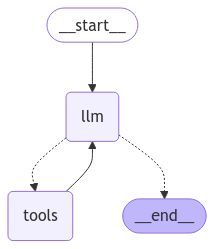

In [30]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


# Answers

In [31]:
# Qual é a composição do suplemento alimentar X?
# Quais são os efeitos do suplemento alimentar X? / O que faz o suplemento alimentar X?
# O que acontece se consumir X e tomar o suplemento alimentar Y?
# Como é o processo de toma do suplemento alimentar X?

# Ingredientes
question1 = "Quais são os ingredientes do Condotril?"
question2 = "Quais são os ingredientes do Duobiotic?"
question3 = "Quais são os ingredientes do Neurofil?"

# Benefícios
question4 = "Quais são os benefícios do Condotril?"
question5 = "Quais são os benefícios do Duobiotic?"
question6 = "Quais são os benefícios do Neurofil?"

# Efeitos
question7 = "Quais são os efeitos do Condotril?"
question8 = "Quais são os efeitos do Duobiotic?"
question9 = "Quais são os efeitos do Nueurofil?"

# Processo de toma
question10 = "Qual é o processo de toma do Condotril?"
question11 = "Qual é o processo de toma do Duobiotic?"
question12 = "Qual é o processo de toma do Neurofil?"

# Condições de armazenamento
question13 = "Quais são as condições de armazenamento do Condotril?"
question14 = "Quais são as condições de armazenamento do Duobiotic?"
question15 = "Quais são as condições de armazenamento do Neurofil?"

# Precaussões
question16 = "Em que casos não se pode tomar Condotril?"
question17 = "Em que casos não se pode tomar Duobiotic?"
question18 = "Em que casos não se pode tomar Neurofil?"

In [33]:
response1 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question1)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='ffbcc25e-d6e8-4f1b-b255-03c972a5419e'),
              HumanMessage(content='Quais são os ingredientes do Condotril?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given co

In [35]:
print("Pergunta: ", question1)
print("Resposta: ", response1['messages'][-1].content)

Pergunta:  Quais são os ingredientes do Condotril?
Resposta:  Os ingredientes do Condotril são:

- Sulfato de Glucosamina
- Sulfato de Condroitina
- MSM (Manganês)
- Vitamina C
- Manganês
- Ácido hialurônico
- Edulcorante: Sucralose

Esses ingredientes são listados em ordem alfabética na fórmula do produto.


In [36]:
response2 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question2)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='ffbcc25e-d6e8-4f1b-b255-03c972a5419e'),
              HumanMessage(content='Quais são os ingredientes do Duobiotic?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given co

In [37]:
print("Pergunta: ", question2)
print("Resposta: ", response2['messages'][-1].content)

Pergunta:  Quais são os ingredientes do Duobiotic?
Resposta:  Os ingredientes do Duobiotic são:

* Fruto-oligossacarídeos
* Inulina
* Maltodextrina de arroz (agente de volume)
* Lactobacillus rhamnosus
* Bifidobacterium bifidum
* Bifidobacterium longum
* Lactobacillus acidophilus
* Lactobacillus bulgaricus
* Streptococcus thermophilus
* Aroma de iogurte
* Dióxido de silício (antiaglomerante)
* Sucralose (edulcorante)
* Nicotinamida (Vitamina B3)
* D-pantotenato de cálcio (Vitamina B5)
* Cloridrato de piridoxina (Vitamina B6)
* Cloridrato de tiameína (Vitamina B1)
* Icido fólico (Icido pteroilmonoglutâmico)
* Filoquinona (Vitamina K)
* Cianocobalamina (Vitamina B12)

Esses ingredientes são encontrados na embalagem do Duobiotic.


In [38]:
response3 = graph.invoke({'messages': [system_prompt, HumanMessage(content=question3)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='ffbcc25e-d6e8-4f1b-b255-03c972a5419e'),
              HumanMessage(content='Quais são os ingredientes do Neurofil?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given con

In [39]:
print("Pergunta: ", question3)
print("Resposta: ", response3['messages'][-1].content)

Pergunta:  Quais são os ingredientes do Neurofil?
Resposta:  Os ingredientes do Neurofil são:

- Proteínas de membrana
- Proteínas de cálcio
- Proteínas de fosfato
- Glicoproteínas
- Lipoproteínas

Esses componentes são presentes na estrutura e função da proteína neurofilamento.


In [41]:
bonus_question = "Qual é a diferença entre Duobiotic e Neurofil?"
response4 = graph.invoke({'messages': [system_prompt, HumanMessage(content=bonus_question)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='ffbcc25e-d6e8-4f1b-b255-03c972a5419e'),
              HumanMessage(content='Qual é a diferença entre Duobiotic e Neurofil?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the g

In [ ]:
import textwrap
line_width = 175  # ajuste para a largura desejada
response4 = textwrap.fill(response4['messages'][-1].content, width=line_width)

print("Pergunta:", bonus_question)
print("Resposta:\n", response4)

Pergunta: Qual é a diferença entre Duobiotic e Neurofil?
Resposta:
 A diferença principal entre Duobiotic e Neurofil é a presença de microrganismos benéficos na formulação do Duobiotic, enquanto que o Neurofil não contém suplementos
alimentares. O Duobiotic é um suplemento alimentar que combina lactobacilos e bifidobacteirias com determinadas substâncias nutrientes, como a inulina, maltodextrina de arroz,
lactobacillos e bifidobacterianas, para promover o crescimento e viabilidade de microrganismos benéficos na flora intestinal. Já o Neurofil é um suplemento alimentar que não
contém microorganismos, mas pode conter substâncias nutrientes e antioxidantes.
